# Exercices
With each exercice will teach you one aspect of deep learning. The process of machine learning can be decompose in 7 steps :

* Data preparation
* Model definition
* Model training
* Model evaluation
* Hyperparameter tuning
* Prediction

## 4 - Model evaluation

- 4.1 Visualize metrics during training (matplot)
- 4.2 Detect overfitting / underfitting
- 4.2 Validate model with unseen dataset
- 4.3 Visualize confusion matrix

### Load dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(images, labels):
    npimg = images.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Ground Truth: {}".format(labels))

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [2]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

data_path = './data'

trans = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# if not exist, download mnist dataset
train_set = dset.MNIST(root=data_path, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=data_path, train=False, transform=trans, download=True)

batch = 4

data_train_loader = DataLoader(train_set, batch_size=batch, shuffle=True, num_workers=8)
data_test_loader = DataLoader(test_set, batch_size=batch, num_workers=8)

### Network architecture

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Load leNet & co.

In [4]:
leVieuxNet = Net()
optimizer = optim.SGD(leVieuxNet.parameters(), lr=0.01)

checkpoint = torch.load('checkpoint-MKTD-pytorch-3.last')
leVieuxNet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

### Compute performance on test set

In [5]:
def compute_accuracy(test_data, network):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data:
            images, labels = data
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [6]:
acc = compute_accuracy(data_test_loader, leVieuxNet)
            
print('Accuracy of the network on the {} test images: {:.3f}%'.format(len(data_test_loader), acc))

Accuracy of the network on the 2500 test images: 96.870%


### Train a new net with another loss 

In [7]:
leNet = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(leNet.parameters(), lr=0.01)

In [8]:
def train(model, criterion, optimizer, train_data, max_epoch):

    for epoch in range(max_epoch):  # loop over the dataset multiple times
        model.train()

        running_loss = 0.0
        for i, (images, labels) in enumerate(train_data):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)

            # align vectors labels <=> outputs
#             label_vect = torch.zeros(outputs.shape[0], outputs.shape[1], dtype=torch.long)
#             for j in range(0, len(labels)):
#                 label_vect[j, labels[j]] = 1.0 
            
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[{:d}] loss: {:.5f}'.format(epoch + 1, running_loss / (batch*len(train_data))))

    print('Finished Training')

In [9]:
train(leNet, criterion, optimizer, data_train_loader, 3)

[1] loss: 0.07958
[2] loss: 0.01790
[3] loss: 0.01248
Finished Training


In [10]:
acc = compute_accuracy(data_test_loader, leNet)
            
print('Accuracy of the network on the {} test images: {:.3f}%'.format(len(data_test_loader), acc))

Accuracy of the network on the 2500 test images: 98.750%


## Testing another gradient descent variant

http://ruder.io/optimizing-gradient-descent/

In [12]:
leNet = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(leNet.parameters(), lr=2e-3)
epoch = 3
train(leNet, criterion, optimizer, data_train_loader, epoch)
acc = compute_accuracy(data_test_loader, leNet)
            
print('Accuracy of the network on the {} test images: {:.3f}%'.format(len(data_test_loader), acc))

[1] loss: 0.03827
[2] loss: 0.02071
[3] loss: 0.01831
Finished Training
Accuracy of the network on the 2500 test images: 98.090%


### Checking precision per class

In [32]:
def perf_analysis(leNet, data_test_loader, classes):

    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int) 

    with torch.no_grad():
        for data in data_test_loader:
            images, labels = data
            outputs = leNet(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                #print('ground thruth={} | prediction={}'.format(label, predicted[i]))
                confusion_matrix[label][predicted[i]] += 1
                
    return class_correct, class_total, confusion_matrix

In [33]:
class_correct, class_total, confusion_matrix = perf_analysis(leNet, data_test_loader, classes)
for i in range(len(classes)):
    print('Precision of {:s}: {:2f}%'.format(classes[i], 100 * class_correct[i] / class_total[i]))

Precision of 0: 99.081633%
Precision of 1: 99.471366%
Precision of 2: 97.965116%
Precision of 3: 98.910891%
Precision of 4: 95.315682%
Precision of 5: 97.645740%
Precision of 6: 98.329854%
Precision of 7: 98.929961%
Precision of 8: 97.433265%
Precision of 9: 97.522299%


### Checking confusion matrix

In [37]:
def display_confusion_matrix(confusion_matrix, classes):
    print(confusion_matrix)

    fig, ax = plt.subplots()
    im = ax.imshow(np.log(confusion_matrix+1))

    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    ax.set_title("Confusion matrix (log scale)")

    plt.xlabel('Predictions')
    plt.ylabel('Ground thruth')

    fig.tight_layout()
    plt.show()

[[ 972    0    1    0    0    1    3    0    1    2]
 [   0 1123    3    4    0    1    2    2    0    0]
 [   1    2  983    5    1    0    0   36    4    0]
 [   0    0    0  997    0   10    0    1    1    1]
 [   0    1    0    0  972    0    0    1    0    8]
 [   0    0    0    6    0  877    3    0    0    6]
 [   5    2    3    0    9    7  927    0    3    2]
 [   0    3    1    0    0    0    0 1022    0    2]
 [   4    1    3    4    4    3    1    8  935   11]
 [   0    2    0    2    5    4    0   11    1  984]]


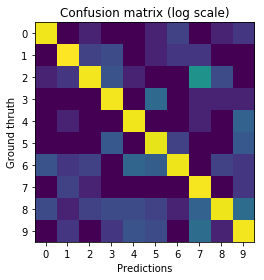

In [38]:
display_confusion_matrix(confusion_matrix, classes)

## And another one

[1] loss: 0.01840
[2] loss: 0.00828
[3] loss: 0.00686
Finished Training
Accuracy of the network on the 1250 test images: 97.760%
[[ 976    0    1    0    0    0    1    1    1    0]
 [   0 1104    2    3    0    0    4   12   10    0]
 [   4    0 1008    2    0    0    0   18    0    0]
 [   0    0    0 1004    0    2    0    3    0    1]
 [   1    3    1    0  894    0    3    7    3   70]
 [   1    0    0    8    0  881    1    1    0    0]
 [   4    2    1    1    1    2  946    0    1    0]
 [   0    0    6    2    0    0    0 1015    0    5]
 [   5    0    2    7    0    1    0    3  955    1]
 [   1    0    0    0    0    2    0    8    5  993]]


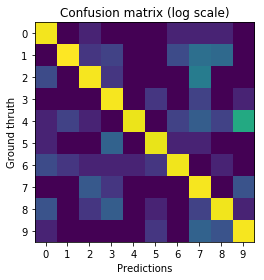

In [39]:
batch = 8

data_train_loader = DataLoader(train_set, batch_size=batch, shuffle=True, num_workers=8)
data_test_loader = DataLoader(test_set, batch_size=batch, num_workers=8)

leNet = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(leNet.parameters(), lr=2e-3)

epoch = 3
train(leNet, criterion, optimizer, data_train_loader, epoch)

acc = compute_accuracy(data_test_loader, leNet)
      
print('Accuracy of the network on the {} test images: {:.3f}%'.format(len(data_test_loader), acc))

class_correct, class_total, confusion_matrix = perf_analysis(leNet, data_test_loader, classes)

display_confusion_matrix(confusion_matrix, classes)

# Metrics visualization

Launch the visdom server by calling in a terminal:
```shell
python -m visdom.server
```
Open http://localhost:8097/ in your browser to conrfirm the server is running

In [134]:
import visdom

def train(model, criterion, optimizer, train_data, max_epoch, batch):
    viz = visdom.Visdom()
    print("Visdom session openned {}".format(viz))
    
    loss_list = list()
    batch_list = list()
    
    moving_average = list()
    moving_average_window = 20
    
    cur_batch_win = None
    cur_batch_win_opts = {
        'title': 'Epoch Loss Trace',
        'xlabel': 'Batch Number',
        'ylabel': 'Loss',
        'linecolor': np.array([[0, 190, 190]]),
        'width': 1200,
        'height': 600,
    }
    avg_batch_win = None
    avg_batch_win_opts = {
        'title': 'Epoch Loss Trace',
        'xlabel': 'Batch Number',
        'ylabel': 'Loss',
        'linecolor': np.array([[0, 100, 100]]),
        'width': 1200,
        'height': 600,
    }
    

    print("Starting training {} epoch over {} data in batch of {} images...".format(max_epoch, len(train_data), batch))
    for epoch in range(max_epoch):  # loop over the dataset multiple times
        model.train()

        running_loss = 0.0
        for i, (images, labels) in enumerate(train_data):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            
            loss = criterion(outputs, labels)

            loss_list.append(loss.detach().cpu().item())
            it = epoch*(len(train_data))+i
            batch_list.append(it+1)
            
            moving_average.append(np.sum(loss_list[max(0,i-moving_average_window):i])/
                                  (1 if it == 0 else it if it < moving_average_window else moving_average_window))
            
            # draw lines
            if viz.check_connection():
                cur_batch_win = viz.line(torch.Tensor(loss_list), torch.Tensor(batch_list), 
                                         win=cur_batch_win, name='current_batch_loss',
                                         update=(None if cur_batch_win is None else 'replace'),
                                         opts=cur_batch_win_opts)
                    
                avg_batch_win = viz.line(torch.Tensor(moving_average), torch.Tensor(batch_list), 
                                         win=cur_batch_win, name='avg_batch_loss',
                                         update=(None if avg_batch_win is None else 'replace'),
                                         opts=avg_batch_win_opts)
            
        
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[{:d}] loss: {:.5f}'.format(epoch + 1, running_loss / (batch*len(train_data))))
        
    print('Finished Training')

## And another one...

In [ ]:
batch = 16

data_train_loader = DataLoader(train_set, batch_size=batch, shuffle=True, num_workers=8)
data_test_loader = DataLoader(test_set, batch_size=batch, num_workers=8)

leNet = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(leNet.parameters(), lr=2e-3)

epoch = 3
train(leNet, criterion, optimizer, data_train_loader, epoch, batch)

acc = compute_accuracy(data_test_loader, leNet)
      
print('Accuracy of the network on the {} test images: {:.3f}%'.format(len(data_test_loader), acc))

class_correct, class_total, confusion_matrix = perf_analysis(leNet, data_test_loader, classes)

display_confusion_matrix(confusion_matrix, classes)

Visdom session openned <visdom.Visdom object at 0x124b98ba8>
Starting training 3 epoch over 3750 data in batch of 16 images...
[1] loss: 0.01024
[2] loss: 0.00383


# TODO

- Fix moving average after each epoch
- Stopping criteria
- Detect overfitting / underfitting

- Testing ignite?
